# Import Necessary Libraries 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('E:\\TFRS\\'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# Any results you write to the current directory are saved as output.

"\nimport os\nfor dirname, _, filenames in os.walk('E:\\TFRS\\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# Importing the Dataset

## Read and Explore the Data

In [23]:
#Import the data set
df = pd.read_csv('Reviews.csv')


In [24]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [25]:
# Dropping the columns
df = df.drop(['Id','Time','HelpfulnessNumerator','HelpfulnessDenominator','Summary'], axis = 1) 


In [26]:
# see few rows of the imported dataset
df.tail()

,ProductId,UserId,ProfileName,Score,Text
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,5,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,2,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",5,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",5,These are the BEST treats for training and rew...
568453,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,5,"I am very satisfied ,product is as advertised,..."


In [27]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  568454
No of columns:  5


In [28]:
#Check Data types
df.dtypes

ProductId      object
UserId         object
ProfileName    object
Score           int64
Text           object
dtype: object

In [29]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 ProductId       0
UserId          0
ProfileName    26
Score           0
Text            0
dtype: int64


### There are no missing values with total records 568454


In [30]:
# Summary statistics of 'rating' variable
df[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


In [31]:
# find minimum and maximum ratings 

def find_min_max_rating():
    print('The minimum rating is: %d' %(df['Score'].min()))
    print('The maximum rating is: %d' %(df['Score'].max()))
    
find_min_max_rating() 

The minimum rating is: 1
The maximum rating is: 5


### Ratings are on scale of 1 - 5


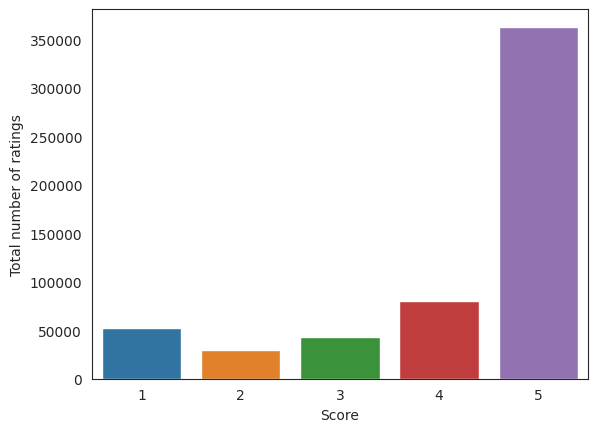

In [32]:
# Check the distribution of ratings
with sns.axes_style('white'):
    g = sns.countplot(data=df, x="Score")
    g.set_ylabel("Total number of ratings")


In [33]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['ProfileName'].nunique())
print('Number of unique USERS in Raw data = ', len(df['ProfileName']))
print('Number of unique ITEMS in Raw data = ', df['Score'].nunique())

Number of unique USERS in Raw data =  218415
Number of unique USERS in Raw data =  568454
Number of unique ITEMS in Raw data =  5


### Take subset of dataset to make it less sparse/more dense. ( For example, keep the users only who has given 50 or more number of ratings )

In [34]:
# Top 10 users based on rating
most_rated = df.groupby('Score').size().sort_values(ascending=False)[:5]
most_rated

Score
5    363122
4     80655
1     52268
3     42640
2     29769
dtype: int64

### Data model preparation as per requirement on number of minimum ratings


In [35]:
counts = df['ProfileName'].value_counts()
df_final = df[df['ProfileName'].isin(counts[counts >= 10].index)]

In [36]:
counts

ProfileName
C. F. Hill "CFH"                               451
O. Brown "Ms. O. Khannah-Brown"                421
Gary Peterson                                  389
Rebecca of Amazon "The Rebecca Review"         365
Chris                                          363
                                              ... 
Steven Wolff                                     1
joycomeau                                        1
Lizz                                             1
Phyllis A. De Smet-Howard "tweedsmerewillo"      1
srfell17                                         1
Name: count, Length: 218415, dtype: int64

In [37]:
df_final.head()

,ProductId,UserId,ProfileName,Score,Text
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2,If you are looking for the secret ingredient i...
11,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",5,One of my boys needed to lose some weight and ...
12,B0009XLVG0,A327PCT23YH90,LT,1,My cats have been happily eating Felidae Plati...
13,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",4,good flavor! these came securely packed... the...
14,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",5,The Strawberry Twizzlers are my guilty pleasur...


In [38]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['ProfileName'].nunique())
print('Number of unique ITEMS in final data = ', df_final['Score'].nunique())

Number of users who have rated 50 or more items = 190432
Number of unique USERS in final data =  8830
Number of unique ITEMS in final data =  5


### Split the data randomly into train and test dataset. ( For example split it in 70/30 ratio)

In [39]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.1, random_state=0)

print(train_data.head(5))

         ProductId          UserId   
473294  B0030VJ79Q  A1SR28GSP1AJ8K  \
31089   B007M83302   AJT8SZ11T4EYP   
406440  B005T12ZVW  A19UTUEBWKIZFT   
327276  B004NM9YW6   A3SG0KEQBXK9O   
112351  B002O7BAB0  A3FJFCAEF7Q1W4   

                                             ProfileName  Score   
473294                                          Mom2JPC3      5  \
31089                                        Jane Austin      5   
406440                                        Bernadette      5   
327276                                             Bruce      4   
112351  Cmonkey "Scuba Diving Photographing Dog Spoil...      5   

                                                     Text  
473294  These pouches are a godsend. I keep a stockpil...  
31089   I absolutely love these chips.  All the flavor...  
406440  Does it make me smarter? Nope. Does it taste f...  
327276  The beauty of the Keurig machine is that you c...  
112351  Lamb is great for sensitive stomachs and this ...  


In [40]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape() 

Test data shape:  (19044, 5)
Train data shape:  (171388, 5)


In [ ]:
######BISA DARI TEXT PREDICT SCORE TP BELUM PER USER
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare the training data
x_train = train_data['ProfileName']
y_train = train_data['Score']

# Prepare the test data
x_test = test_data['ProfileName']0
y_test = test_data['Score']

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

true_train = tokenizer.texts_to_sequences(x_train)
true_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = 200

true_train2 = pad_sequences(true_train, maxlen=max_length, padding='post')
true_test2 = pad_sequences(true_test, maxlen=max_length, padding='post')

# Scale the ratings between 0 and 1
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))

# Create the model
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(true_train2, y_train, epochs=10, batch_size=32, validation_split=0.2)

'''
# Predict the ratings for the test set
predictions = model.predict(true_test2)

# Inverse transform the scaled ratings to get the actual ratings
predicted_ratings = scaler.inverse_transform(predictions)

# Create a DataFrame with the predicted ratings and original ratings
predicted_df = pd.DataFrame({
    'PredictedRating': predicted_ratings.flatten(),
    'OriginalRating': y_test.values.flatten()
})

print(predicted_df.head())
'''

In [ ]:
import numpy as np

# Define custom scaling function
def custom_scaling(data, min_value, max_value):
    # Compute the minimum and maximum values of the data
    data_min = np.min(data)
    data_max = np.max(data)
    
    # Scale the data using linear transformation
    #scaled_data = (data - data_min) * (max_value - min_value) / (data_max - data_min) + min_value
    scaled_data = (data - data_min) / (data_max - data_min)
    return scaled_data

def inverse_custom_scaling(scaled_data, min_value, max_value):
    # Compute the minimum and maximum values of the scaled data range
    scaled_min = np.min(scaled_data)
    scaled_max = np.max(scaled_data)
    
    # Reverse the scaling using the inverse linear transformation
    #data = (scaled_data - min_value) * (scaled_max - scaled_min) / (max_value - min_value) + scaled_min
    data = scaled_data * (max_value - min_value) + min_value
    return data

# Example usage
data = np.array([2, 5, 8, 12, 15])  # Sample data
scaled_data = custom_scaling(data, 0, 1)  # Custom scaling between 0 and 1

print("Original Data:", data)
print("Scaled Data:", scaled_data)


In [41]:
######BISA DARI PROFILE NAME PREDICT SCORE TP BELUM PER USER
#### APA BISA X nya 2 buah?
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler,Normalizer,PowerTransformer

# Prepare the training data
#x1_train = train_data['ProfileName'] #check data size first PLS !
x1_train = train_data['UserId'] 
x2_train = train_data['ProductId']
y_train = train_data['Score']

# Prepare the test data
#x1_test = test_data['ProfileName']
x1_test = test_data['UserId']
x2_test = test_data['ProductId']
y_test = test_data['Score']

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x1_train)
tokenizer.fit_on_texts(x2_train)

true_train1 = tokenizer.texts_to_sequences(x1_train)
true_train2 = tokenizer.texts_to_sequences(x2_train)
true_test1 = tokenizer.texts_to_sequences(x1_test)
true_test2 = tokenizer.texts_to_sequences(x2_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = 50

true_trainX = pad_sequences(true_train1, maxlen=max_length, padding='post')
true_trainX2 = pad_sequences(true_train2, maxlen=max_length, padding='post')
true_testX = pad_sequences(true_test1, maxlen=max_length, padding='post')
true_testX2 = pad_sequences(true_test2, maxlen=max_length, padding='post')

x_train = np.concatenate((true_trainX, true_trainX2), axis=1)
x_test = np.concatenate((true_testX, true_testX2), axis=1)

# Scale the ratings between 0 and 1
scaler = MinMaxScaler()
y_train2 = scaler.fit_transform(y_train.values.reshape(-1, 1))
#y_train2 = custom_scaling(y_train.values.reshape(-1,1),0,1)


In [ ]:
true_trainX2.shape

In [ ]:
######BISA DARI TEXT PREDICT SCORE TP BELUM PER USER
#### APA BISA X nya 2 buah?
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler,Normalizer,PowerTransformer

# Prepare the training data
x1_train = train_data['Text'] #check data size first PLS !
x2_train = train_data['ProductId']
y_train = train_data['Score']

# Prepare the test data
x1_test = test_data['Text']
x2_test = test_data['ProductId']
y_test = test_data['Score']

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x1_train)
tokenizer.fit_on_texts(x2_train)

true_train1 = tokenizer.texts_to_sequences(x1_train)
true_train2 = tokenizer.texts_to_sequences(x2_train)
true_test1 = tokenizer.texts_to_sequences(x1_test)
true_test2 = tokenizer.texts_to_sequences(x2_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = 50

true_trainX = pad_sequences(true_train1, maxlen=max_length, padding='post')
true_trainX2 = pad_sequences(true_train2, maxlen=max_length, padding='post')
true_testX = pad_sequences(true_test1, maxlen=max_length, padding='post')
true_testX2 = pad_sequences(true_test2, maxlen=max_length, padding='post')

x_train = np.concatenate((true_trainX, true_trainX2), axis=1)
x_test = np.concatenate((true_testX, true_testX2), axis=1)

# Scale the ratings between 0 and 1
scaler = MinMaxScaler()
y_train2 = scaler.fit_transform(y_train.values.reshape(-1, 1))
#y_train2 = custom_scaling(y_train.values.reshape(-1,1),0,1)


In [ ]:
######BISA DARI TEXT PREDICT SCORE TP BELUM PER USER
#### APA BISA X nya 2 buah?
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler,Normalizer,PowerTransformer

# Prepare the training data
x1_train = train_data['ProfileName'] #check data size first PLS !
x2_train = train_data['ProductId']
x3_train = train_data['Text']
y_train = train_data['Score']

# Prepare the test data
x1_test = test_data['ProfileName']
x2_test = test_data['ProductId']
x3_test = train_data['Text']
y_test = test_data['Score']

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x1_train)
tokenizer.fit_on_texts(x2_train)
tokenizer.fit_on_texts(x3_train)
tokenizer.fit_on_texts(x1_test)
tokenizer.fit_on_texts(x2_test)
tokenizer.fit_on_texts(x3_test)

true_train1 = tokenizer.texts_to_sequences(x1_train)
true_train2 = tokenizer.texts_to_sequences(x2_train)
true_train3 = tokenizer.texts_to_sequences(x3_train)
true_test1 = tokenizer.texts_to_sequences(x1_test)
true_test2 = tokenizer.texts_to_sequences(x2_test)
true_test3 = tokenizer.texts_to_sequences(x3_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = 50

true_trainX = pad_sequences(true_train1, maxlen=max_length, padding='post')
true_trainX2 = pad_sequences(true_train2, maxlen=max_length, padding='post')
true_trainX3 = pad_sequences(true_train3, maxlen=max_length, padding='post')
true_testX = pad_sequences(true_test1, maxlen=max_length, padding='post')
true_testX2 = pad_sequences(true_test2, maxlen=max_length, padding='post')
true_testX3 = pad_sequences(true_test3, maxlen=max_length, padding='post')

x_train = np.concatenate((true_trainX, true_trainX2), axis=1)
x_train2 = np.concatenate((x_train, true_trainX3), axis=1)
#x_test = np.concatenate((true_testX, true_testX2), axis=1)
#x_test2 = np.concatenate((x_test, true_testX3), axis=1)

# Scale the ratings between 0 and 1
scaler = MinMaxScaler()
y_train2 = scaler.fit_transform(y_train.values.reshape(-1, 1))
#y_train2 = custom_scaling(y_train.values.reshape(-1,1),0,1)


In [ ]:
true_trainX.shape

In [42]:
# Create the model
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(x_train[:,:50], y_train2, epochs=10, batch_size=32, validation_split=0.2)

'''
# Predict the ratings for the test set
predictions = model.predict(true_test2)

# Inverse transform the scaled ratings to get the actual ratings
predicted_ratings = scaler.inverse_transform(predictions)

# Create a DataFrame with the predicted ratings and original ratings
predicted_df = pd.DataFrame({
    'PredictedRating': predicted_ratings.flatten(),
    'OriginalRating': y_test.values.flatten()
})

print(predicted_df.head())
'''

Epoch 1/10
4285/4285 [==============================] - 27s 6ms/step - loss: 0.1034 - accuracy: 0.6060 - val_loss: 0.0989 - val_accuracy: 0.6036
Epoch 2/10
4285/4285 [==============================] - 26s 6ms/step - loss: 0.1007 - accuracy: 0.6073 - val_loss: 0.0995 - val_accuracy: 0.6036
Epoch 3/10
4285/4285 [==============================] - 26s 6ms/step - loss: 0.0999 - accuracy: 0.6073 - val_loss: 0.0990 - val_accuracy: 0.6036
Epoch 4/10
4285/4285 [==============================] - 26s 6ms/step - loss: 0.0995 - accuracy: 0.6073 - val_loss: 0.0989 - val_accuracy: 0.6036
Epoch 5/10
4285/4285 [==============================] - 26s 6ms/step - loss: 0.0992 - accuracy: 0.6073 - val_loss: 0.0991 - val_accuracy: 0.6036
Epoch 6/10
4285/4285 [==============================] - 26s 6ms/step - loss: 0.0990 - accuracy: 0.6073 - val_loss: 0.0989 - val_accuracy: 0.6036
Epoch 7/10
4285/4285 [==============================] - 26s 6ms/step - loss: 0.0989 - accuracy: 0.6073 - val_loss: 0.0989 - val_ac

"\n# Predict the ratings for the test set\npredictions = model.predict(true_test2)\n\n# Inverse transform the scaled ratings to get the actual ratings\npredicted_ratings = scaler.inverse_transform(predictions)\n\n# Create a DataFrame with the predicted ratings and original ratings\npredicted_df = pd.DataFrame({\n    'PredictedRating': predicted_ratings.flatten(),\n    'OriginalRating': y_test.values.flatten()\n})\n\nprint(predicted_df.head())\n"

In [ ]:
# Predict the ratings for the test set
predictions = model.predict(x_test[:,:50])

# Inverse transform the scaled ratings to get the actual ratings
predicted_ratings = scaler.inverse_transform(predictions)
#predicted_ratings = inverse_custom_scaling(predictions,0,1)

In [ ]:
predicted_ratings

In [ ]:
# Convert 'UserId' and 'ProductId' to data arrays
name_idx = train_data['ProfileName'].values
product_idx = train_data['ProductId'].values

# Create a new DataFrame with converted data arrays
df_converted = pd.DataFrame({'ProfileName': name_idx, 'ProductId': product_idx, 'Score': 0})

# Create pivot table with the converted DataFrame
final_ratings_matrix = pd.pivot_table(df_converted, index='ProfileName', columns='ProductId', values='Score')
final_ratings_matrix.fillna(0, inplace=True)

# Print the final_ratings_matrix
final_ratings_matrix


In [ ]:
import numpy as np
import pandas as pd

# Assuming 'final_ratings_matrix' is a pandas DataFrame containing the pivot table
# obtained from pd.pivot_table()

# Fill NaN values with 0
final_ratings_matrix.fillna(0, inplace=True)

# Convert the DataFrame to a NumPy array
array3 = final_ratings_matrix.reset_index().melt(id_vars=['ProfileName'], value_vars=final_ratings_matrix.columns)
array3.columns = ['ProfileName', 'ProductId', 'Score']
array3 = array3[['ProfileName', 'ProductId']].values

# Print the resulting array
print(type(array3))
print(array3)

In [ ]:
# ARRAY TEST UNTUK TEXT
import numpy as np
import pandas as pd

# Assuming 'final_ratings_matrix' is a pandas DataFrame containing the pivot table
# obtained from pd.pivot_table()

# Fill NaN values with 0
final_ratings_matrix.fillna(0, inplace=True)

# Convert the DataFrame to a NumPy array
array3 = final_ratings_matrix.reset_index().melt(id_vars=['ProfileName'], value_vars=final_ratings_matrix.columns)
array3.columns = ['ProfileName', 'ProductId', 'Score']
#array3 = array3[['ProfileName', 'ProductId']].values

# Print the resulting array
print(type(array3))
print(array3)

In [ ]:
x_test

In [ ]:
# Predict the ratings for the test set
ratings = model.predict(array3)

# Inverse transform the scaled ratings to get the actual ratings
predicted_ratings = scaler.inverse_transform(ratings)

# Create a new DataFrame with the columns from 'array3' and the 'predicted_ratings'
df_predict = pd.DataFrame(array3, columns=['ProfileName', 'ProductId'])
df_predict['PredictedRating'] = predicted_ratings

# Print the updated DataFrame
df_predict

In [ ]:
df_predict

In [ ]:
df_predict.to_csv('ratingpredict_resulted.csv', index=False)

In [ ]:
# Plot the model accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_data

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare the training data
x_train = train_data['ProfileName'].unique()
y_train = train_data['Score']

# Prepare the test data
x_test = test_data['ProfileName']
y_test = test_data['Score']

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

true_train = tokenizer.texts_to_sequences(x_train)
true_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = 200

true_train2 = pad_sequences(true_train, maxlen=max_length, padding='post')
true_test2 = pad_sequences(true_test, maxlen=max_length, padding='post')

# Scale the ratings between 0 and 1
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))

# Create the model
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(true_train2, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict the ratings for the test set
predictions = model.predict(true_test2)

# Inverse transform the scaled ratings to get the actual ratings
predicted_ratings = scaler.inverse_transform(predictions)

# Create a DataFrame with the predicted ratings and original ratings
predicted_df = pd.DataFrame({
    'PredictedRating': predicted_ratings.flatten(),
    'OriginalRating': y_test.values.flatten()
})

print(predicted_df.head())


In [ ]:
# Plot the model accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#####USING BERT PRETRAINED
# Load the BERT model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFDistilBertForSequenceClassification

# Load the pretrained DistilBERT model for sequence classification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Set the input shapes
input_ids = Input(shape=(max_length,), dtype=tf.int64)
attention_mask = Input(shape=(max_length,), dtype=tf.int64)

# Get the BERT output
bert_output = model(input_ids, attention_mask=attention_mask)[0]

# Create the model architecture
dense_layer = Dense(128, activation='relu')(bert_output)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='linear')(dropout_layer)

# Combine the input and output layers into a model
model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit([true_trainX, true_trainX2], y_train, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
#####USING XLNET PRETRAINED
# Load the BERT model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFXLNetModel

xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-uncased')

# Set the input shapes
input_ids = Input(shape=(max_length,), dtype=tf.int64)
attention_mask = Input(shape=(max_length,), dtype=tf.int64)

# Get the BERT output
xlnet_output = xlnet_model(input_ids=input_ids, attention_mask=attention_mask)[0]

# Create the model architecture
model = tf.keras.Sequential()
model.add(xlnet_output)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Combine the input and output layers into a model
model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit([true_trainX, true_trainX2], y_train, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
#####USING BERT PRETRAINED
# Load the BERT model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Set the input shapes
input_ids = Input(shape=(max_length,), dtype=tf.int32)
attention_mask = Input(shape=(max_length,), dtype=tf.int32)

# Get the BERT output
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]

# Create the model architecture
dense_layer = Dense(128, activation='relu')(bert_output)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='linear')(dropout_layer)

# Combine the input and output layers into a model
model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit([true_trainX, true_trainX2], y_train, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
# Set the input shape for the base model
input_ids = Input(shape=(max_seq_length,), dtype=tf.int32)
attention_mask = Input(shape=(max_seq_length,), dtype=tf.int32)

# Pass the inputs through the base model
bert_output = base_model(input_ids, attention_mask=attention_mask)[0]

# Add additional layers on top of the BERT output
x = Dense(128, activation='relu')(bert_output)
output = Dense(1, activation='linear')(x)

# Create the final model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# tflite

In [ ]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
#POST TRAIN QUANTIZATION
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
import pathlib
tflite_model_file = pathlib.Path(export_dir+'/recommender_model.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
model.save(export_dir+'/recommender_model.h5')